In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import logsumexp     


from hmmlearn.hmm import GaussianHMM
from sklearn.cluster import KMeans

from jumpmodels.sparse_jump import SparseJumpModel
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import expected_returns, risk_models
from pypfopt.black_litterman import BlackLittermanModel

In [ ]:
ASSETS = ["Value", "Growth", "LowVol", "Size", "Momentum", "Quality"]
N_ASSETS = len(ASSETS)

def simulate_1state_data(num_days, seed=None):
    rng = np.random.default_rng(seed)
    mu = 0.000461
    sig = 0.008388

    corr = np.full((N_ASSETS, N_ASSETS), 0.185)
    np.fill_diagonal(corr, 1.0)
    cov = np.outer(np.full(N_ASSETS, sig), np.full(N_ASSETS, sig)) * corr

    rets = rng.multivariate_normal(
        mean=np.full(N_ASSETS, mu),
        cov=cov,
        size=num_days
    )
    return pd.DataFrame(rets, columns=ASSETS)

def simulate_2state_data(num_days, seed=None):
    rng = np.random.default_rng(seed)
    transmat = np.array([[0.9976, 0.0024],
                         [0.0232, 0.9768]])
    mu_dict  = {0: 0.0006,   1: -0.000881}
    sig_dict = {0: 0.00757,  1: 0.0163}

    base_corr = np.full((N_ASSETS, N_ASSETS), 0.185)
    np.fill_diagonal(base_corr, 1.0)

    all_states = np.zeros((num_days, N_ASSETS), dtype=int)
    for i in range(N_ASSETS):
        s = np.zeros(num_days, dtype=int)
        s[0] = rng.integers(2)
        for t in range(1, num_days):
            s[t] = rng.choice(2, p=transmat[s[t - 1]])
        all_states[:, i] = s

    rets = np.zeros((num_days, N_ASSETS))
    for t in range(num_days):
        mu_vec  = np.zeros(N_ASSETS)
        sig_vec = np.zeros(N_ASSETS)
        for i in range(N_ASSETS):
            curr_state = all_states[t, i]
            mu_vec[i]  = mu_dict[curr_state]
            sig_vec[i] = sig_dict[curr_state]
        cov_t = np.outer(sig_vec, sig_vec) * base_corr
        rets[t] = rng.multivariate_normal(mean=mu_vec, cov=cov_t)

    return pd.DataFrame(rets, columns=ASSETS), all_states

def simulate_3state_data(num_days, seed=None):
    rng = np.random.default_rng(seed)
    transmat = np.array([
        [0.9989, 0.0004, 0.0007],
        [0.0089, 0.9904, 0.0007],
        [0.0089, 0.0004, 0.9907]
    ])
    mu_list  = [0.0008, 0.0,     -0.003586]
    sig_list = [0.0070, 0.0050,  0.01897]

    base_corr = np.full((N_ASSETS, N_ASSETS), 0.185)
    np.fill_diagonal(base_corr, 1.0)

    all_states = np.zeros((num_days, N_ASSETS), dtype=int)
    for i in range(N_ASSETS):
        s = np.zeros(num_days, dtype=int)
        s[0] = rng.integers(3)
        for t in range(1, num_days):
            s[t] = rng.choice(3, p=transmat[s[t - 1]])
        all_states[:, i] = s

    rets = np.zeros((num_days, N_ASSETS))
    for t in range(num_days):
        mu_vec  = np.zeros(N_ASSETS)
        sig_vec = np.zeros(N_ASSETS)
        for i in range(N_ASSETS):
            st_i   = all_states[t, i]
            mu_vec[i]  = mu_list[st_i]
            sig_vec[i] = sig_list[st_i]
        cov_t = np.outer(sig_vec, sig_vec) * base_corr
        rets[t] = rng.multivariate_normal(mean=mu_vec, cov=cov_t)

    return pd.DataFrame(rets, columns=ASSETS), all_states

In [3]:
def run_mle(observations, n_components=2, init_type='default', seed=None):
    model = GaussianHMM(
        n_components=n_components,
        covariance_type='diag',
        n_iter=100,
        random_state=seed
    )
    if init_type == 'default':
        model.startprob_ = np.array([1.0, 0.0])
        model.transmat_  = np.array([
            [0.9, 0.1],
            [0.1, 0.9]
        ])
        model.means_  = np.zeros((n_components, observations.shape[1]))
        model.covars_ = np.full((n_components, observations.shape[1]), 1e-10)
        model.init_params = ''
    elif init_type == 'kmeans':
        km = KMeans(n_clusters=n_components, n_init=10, random_state=seed)
        labels = km.fit_predict(observations)
        means, covars = [], []
        for i in range(n_components):
            obs_i = observations[labels == i]
            means.append(np.mean(obs_i, axis=0))
            covars.append(np.var(obs_i, axis=0) + 1e-10)
        model.startprob_ = np.ones(n_components) / n_components
        model.transmat_  = np.ones((n_components, n_components)) / n_components
        model.means_     = np.array(means)
        model.covars_    = np.array(covars)
        model.init_params = ''

    model.fit(observations)
    pred_states = model.predict(observations)
    return model, pred_states

def run_mle_default(observations, seed=None):
    return run_mle(observations, init_type='default', seed=seed)

def run_mle_kmeans(observations, seed=None):
    return run_mle(observations, init_type='kmeans', seed=seed)

def train_hmm_single_asset_default(series, n_components=2, random_state=42):
    X = series.values.reshape(-1, 1)
    model, _ = run_mle_default(X, seed=random_state)
    return model

def train_hmm_single_asset_kmeans(series, n_components=2, random_state=42):
    X = series.values.reshape(-1, 1)
    model, _ = run_mle_kmeans(X, seed=random_state)
    return model

In [4]:
def compute_sjm_features(factor_ser: pd.Series) -> pd.DataFrame:
    def ewm_downside_dev(returns: pd.Series, halflife: float) -> pd.Series:
        negative_returns = returns.clip(upper=0)
        neg_sq = negative_returns ** 2
        ewm_mean = neg_sq.ewm(halflife=halflife, adjust=False).mean()
        return np.sqrt(ewm_mean)

    dd20 = ewm_downside_dev(factor_ser, halflife=20)
    dd60 = ewm_downside_dev(factor_ser, halflife=60)
    dd120 = ewm_downside_dev(factor_ser, halflife=120)

    feat_dd20 = dd20
    feat_dd20_minus_dd60 = dd20 - dd60
    feat_dd60_minus_dd120 = dd60 - dd120
    ret_hl120 = factor_ser.ewm(halflife=120, adjust=False).mean()

    feats = {
        "DD_hl20": feat_dd20,
        "DD20_minus_DD60": feat_dd20_minus_dd60,
        "DD60_minus_DD120": feat_dd60_minus_dd120,
        "Return_hl120": ret_hl120,
    }
    df_feats = pd.DataFrame(feats)
    df_feats = df_feats.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return df_feats

def train_sjm_single_asset(series, n_components=2, max_feats=4, lam=50, random_state=42):
    feats_df = compute_sjm_features(series)
    feats_df = feats_df.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    clipper = DataClipperStd(mul=3.0)
    scaler  = StandardScalerPD()

    X_clipped = clipper.fit_transform(feats_df)
    X_scaled  = scaler.fit_transform(X_clipped)
    X_arr = X_scaled.values

    sjm = SparseJumpModel(
        n_components=n_components,
        max_feats=max_feats,
        jump_penalty=lam,
        cont=False,
        max_iter=20,
        random_state=random_state
    )
    sjm.fit(X_arr)

    return sjm, clipper, scaler

In [ ]:
def get_rolling_cov(full_returns, current_index, halflife=126):
    sub_df = full_returns.iloc[:current_index]
    if len(sub_df) < 2:
        n_ = sub_df.shape[1]
        return np.eye(n_)
    span_equiv = (2 / (1 - np.exp(-np.log(2)/halflife))) - 1
    cov_est = risk_models.exp_cov(sub_df, span=span_equiv, returns_data=True)
    return cov_est

def backtest_portfolio(
        returns: pd.DataFrame,
        target_weights: np.ndarray,
        transaction_cost: float = 0.0007,
        rebalance_freq: int | None = None,   
        return_weights: bool = False,
        return_trades:  bool = False,
):
    T, _ = returns.shape
    pv   = np.ones(T)
    w    = target_weights.copy()

    W_hist, trades = [w.copy()], []

    pv[0] -= transaction_cost * np.abs(w).sum()

    for t in range(1, T):
        ret_vec = returns.iloc[t-1].values

        pv[t] = pv[t-1] * (1 + np.dot(w, ret_vec))

        w *= (1 + ret_vec)
        w /= w.sum()

        traded_today = 0.0
        if rebalance_freq and t % rebalance_freq == 0:
            traded_today = np.abs(w - target_weights).sum()
            pv[t] -= pv[t] * traded_today * transaction_cost
            w = target_weights.copy()

        W_hist.append(w.copy())
        trades.append(traded_today)

    out = (pv,)
    if return_weights:
        out += (np.asarray(W_hist),)
    if return_trades:
        out += (np.asarray(trades),)
    return out if len(out) > 1 else out[0]


In [6]:
def compute_performance_metrics(pv,
                                trade_sizes=None,
                                annual_factor: int = 250):
    pv = np.asarray(pv)
    rets = np.diff(pv) / pv[:-1]

    ann_ret = rets.mean() * annual_factor
    cum_ret = pv[-1] / pv[0] - 1
    ann_vol = rets.std() * np.sqrt(annual_factor)

    downside = rets[rets < 0]
    ddev     = downside.std() * np.sqrt(annual_factor) if len(downside) else 0
    max_dd   = (pv / np.maximum.accumulate(pv) - 1).min()

    sharpe  = ann_ret / (ann_vol + 1e-12)
    sortino = ann_ret / ddev if ddev > 1e-12 else np.nan
    calmar  = ann_ret / abs(max_dd) if max_dd < 0 else np.nan

    turnover = np.mean(trade_sizes) if trade_sizes is not None else 0.0

    return {"Annualized Return": ann_ret,
            "Cumulative Return": cum_ret,
            "Volatility": ann_vol,
            "Downside Deviation": ddev,
            "Max Drawdown": max_dd,
            "Sharpe Ratio": sharpe,
            "Sortino Ratio": sortino,
            "Calmar Ratio": calmar,
            "Turnover Rate": turnover}

In [ ]:
def filter_hidden_states(model: GaussianHMM, X: np.ndarray) -> np.ndarray:
    loglik      = model._compute_log_likelihood(X)
    T, n_states = loglik.shape
    log_start   = np.log(model.startprob_)
    log_trans   = np.log(model.transmat_)

    alpha = np.empty((T, n_states))
    alpha[0] = log_start + loglik[0]
    alpha[0] -= logsumexp(alpha[0])

    for t in range(1, T):
        for j in range(n_states):
            alpha[t, j] = loglik[t, j] + logsumexp(alpha[t-1] + log_trans[:, j])
        alpha[t] -= logsumexp(alpha[t])

    return alpha.argmax(axis=1)

In [ ]:
def regime_based_bl_backtest(
        df_train,
        df_test,
        states_test,
        regime_means_list,
        init_state,
        risk_free_rate=0.02 / 252,
        transaction_cost=0.0007,
        bl_tau=0.05,
        halflife=126,
):
    T_test   = len(df_test)
    assets   = df_test.columns
    n_assets = len(assets)

    combined_df = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

    pv  = np.ones(T_test)
    w   = np.ones(n_assets) / n_assets           
    W   = np.zeros((T_test, n_assets)); W[0] = w

    trades   = [0.0]                            
    fallback = []

    for t in range(1, T_test):
        ret_vec = df_test.iloc[t-1].values

        pv[t] = pv[t-1] * (1 + np.dot(w, ret_vec))

        w = w * (1 + ret_vec)
        w = w / w.sum()

        if t == 1:
            current_states = init_state
            do_reb         = True
        else:
            current_states = states_test[t-1]
            do_reb         = not np.all(current_states == states_test[t-2])

        traded_today = 0.0
        if do_reb:
            view_vec = np.array([
                regime_means_list[i].get(current_states[i], 0.0)
                for i in range(n_assets)
            ])

            cov_t = get_rolling_cov(combined_df, len(df_train) + t, halflife)
            bl = BlackLittermanModel(
                cov_matrix=cov_t,
                pi="equal",
                absolute_views=dict(zip(assets, view_vec)),
                tau=bl_tau,
                risk_aversion=2.5,
            )
            ef = EfficientFrontier(bl.bl_returns(), cov_t,
                                   weight_bounds=(0, 1), solver="SCS")
            try:
                w_dict = ef.max_sharpe(risk_free_rate=risk_free_rate)
            except ValueError:                    
                w_dict = {a: 1.0 / n_assets for a in assets}
                fallback.append({"t": t, "states": current_states.copy()})

            w_new        = np.array([w_dict[a] for a in assets])
            traded_today = np.abs(w_new - w).sum()
            pv[t]       -= pv[t] * traded_today * transaction_cost
            w            = w_new

        W[t] = w
        trades.append(traded_today)

    return pv, W, np.asarray(trades), fallback

In [ ]:
def get_regime_means_stds_single_asset(asset_series, regime_assignments):

    unique_states = np.unique(regime_assignments)
    regime_means = {}
    for s in unique_states:
        data_in_s = asset_series[regime_assignments == s]
        if len(data_in_s) > 0:
            regime_means[s] = data_in_s.mean()
        else:
            regime_means[s] = 0.0
    return regime_means

def equal_weight_allocation(n):
    return np.ones(n) / n

def inverse_vol_weights(df):
    stds = df.std(axis=0).values + 1e-12
    w = 1.0 / stds
    return w / w.sum()

def static_mvo_allocation(df, risk_free_rate=0.02/252):
    mu = expected_returns.mean_historical_return(df, frequency=252)
    cov = risk_models.sample_cov(df)
    try:
        ef = EfficientFrontier(mu, cov, weight_bounds=(0, 1), solver="SCS")
        w_dict = ef.max_sharpe(risk_free_rate=risk_free_rate)
    except Exception as e:
        print("max_sharpe failed:", e)
        ef_alt = EfficientFrontier(mu, cov, weight_bounds=(0, 1), solver="SCS")
        w_dict = ef_alt.min_volatility()
    return w_dict


In [ ]:

def run_allocation(df, lam_sjm=50, scenario_name=""):
    split_idx = int(len(df) * 0.8)
    df_train  = df.iloc[:split_idx]
    df_test   = df.iloc[split_idx:]
    T_test    = len(df_test)

    st_hmm_def_tr = np.zeros((split_idx, N_ASSETS), dtype=int)
    st_hmm_km_tr  = np.zeros((split_idx, N_ASSETS), dtype=int)
    st_sjm_tr     = np.zeros((split_idx, N_ASSETS), dtype=int)

    st_hmm_def_te = np.zeros((T_test, N_ASSETS), dtype=int)
    st_hmm_km_te  = np.zeros((T_test, N_ASSETS), dtype=int)
    st_sjm_te     = np.zeros((T_test, N_ASSETS), dtype=int)

    hmm_def, hmm_km, sjm_mods, sjm_clip, sjm_scal = [], [], [], [], []

    for j, a in enumerate(ASSETS):
        m_def = train_hmm_single_asset_default(df_train[a])
        hmm_def.append(m_def)
        full_X = df[a].values.reshape(-1, 1)
        st_full = filter_hidden_states(m_def, full_X)
        st_hmm_def_tr[:, j] = st_full[:split_idx]
        st_hmm_def_te[:, j] = st_full[split_idx:]

        m_km = train_hmm_single_asset_kmeans(df_train[a])
        hmm_km.append(m_km)
        st_full = filter_hidden_states(m_km, full_X)
        st_hmm_km_tr[:, j] = st_full[:split_idx]
        st_hmm_km_te[:, j] = st_full[split_idx:]

        sjm, clip, scl = train_sjm_single_asset(df_train[a], lam=lam_sjm)
        sjm_mods.append(sjm); sjm_clip.append(clip); sjm_scal.append(scl)

        feats_full = compute_sjm_features(df[a]).fillna(0.0)
        X_full     = scl.transform(clip.transform(feats_full)).values
        st_full    = sjm.predict(X_full)
        st_sjm_tr[:, j] = st_full[:split_idx]
        st_sjm_te[:, j] = st_full[split_idx:]

    def _means(mat):
        return [get_regime_means_stds_single_asset(df_train.iloc[:, k], mat[:, k])
                for k in range(N_ASSETS)]

    reg_hmm_def = _means(st_hmm_def_tr)
    reg_hmm_km  = _means(st_hmm_km_tr)
    reg_sjm     = _means(st_sjm_tr)

    w_ew  = np.ones(N_ASSETS) / N_ASSETS
    pv_ew,  W_ew,  T_ew  = backtest_portfolio(
        df_test, w_ew, 0.0007,
        rebalance_freq=63,
        return_weights=True,          
        return_trades=True)

    w_iv  = inverse_vol_weights(df_test)
    pv_iv, W_iv, T_iv  = backtest_portfolio(
        df_test, w_iv, 0.0007,
        return_weights=True,          
        return_trades=True)

    w_mvo_dict = static_mvo_allocation(df_train)
    w_mvo = np.array([w_mvo_dict[a] for a in df_train.columns])
    pv_mvo, W_mvo, T_mvo = backtest_portfolio(
        df_test, w_mvo, 0.0007,
        rebalance_freq=63,
        return_weights=True,          
        return_trades=True)

    pv_hmm_d, W_hmm_d, T_hmm_d, fb_d = regime_based_bl_backtest(
        df_train, df_test, st_hmm_def_te, reg_hmm_def, st_hmm_def_tr[-1])

    pv_hmm_k, W_hmm_k, T_hmm_k, fb_k = regime_based_bl_backtest(
        df_train, df_test, st_hmm_km_te, reg_hmm_km, st_hmm_km_tr[-1])

    pv_sjm,   W_sjm,   T_sjm,   fb_sjm = regime_based_bl_backtest(
        df_train, df_test, st_sjm_te, reg_sjm,   st_sjm_tr[-1])

    perf = {
        "EW":   compute_performance_metrics(pv_ew,  trade_sizes=T_ew ),
        "MVO":  compute_performance_metrics(pv_mvo, trade_sizes=T_mvo),
        "HMM-BL-Default": compute_performance_metrics(pv_hmm_d, trade_sizes=T_hmm_d),
        "HMM-BL-KMeans":  compute_performance_metrics(pv_hmm_k, trade_sizes=T_hmm_k),
        "SJM-BL":         compute_performance_metrics(pv_sjm,   trade_sizes=T_sjm ),
    }

    pvs = {
        "EW": pv_ew, 
        "MVO": pv_mvo,
        "HMM-BL-Default": pv_hmm_d,
        "HMM-BL-KMeans":  pv_hmm_k,
        "SJM-BL":         pv_sjm,
    }

    weights = {
        "EW": W_ew, 
        "MVO": W_mvo,
        "HMM-BL-Default": W_hmm_d,
        "HMM-BL-KMeans":  W_hmm_k,
        "SJM-BL":         W_sjm,
    }

    fallbacks = {"HMM-BL-Default": fb_d,
                 "HMM-BL-KMeans":  fb_k,
                 "SJM-BL":         fb_sjm}

    return perf, pvs, weights, fallbacks

In [ ]:
def run_scenario_123(T_sim=1000, lam_sjm=50):
    df1_full = simulate_1state_data(T_sim, seed=123)
    perf_1, pvs_1, w_1, fb_1 = run_allocation(df1_full, lam_sjm=lam_sjm, scenario_name="1-state")

    df2_full, _ = simulate_2state_data(T_sim, seed=123)
    perf_2, pvs_2, w_2, fb_2 = run_allocation(df2_full, lam_sjm=lam_sjm, scenario_name="2-state")

    df3_full, _ = simulate_3state_data(T_sim, seed=123)
    perf_3, pvs_3, w_3, fb_3 = run_allocation(df3_full, lam_sjm=lam_sjm, scenario_name="3-state")

    return {
        "1state": {"perf": perf_1, "pvs": pvs_1, "weights": w_1, "fallbacks": fb_1},
        "2state": {"perf": perf_2, "pvs": pvs_2, "weights": w_2, "fallbacks": fb_2},
        "3state": {"perf": perf_3, "pvs": pvs_3, "weights": w_3, "fallbacks": fb_3},
    }

In [ ]:
if __name__ == "__main__":
    results = run_scenario_123(T_sim=5040, lam_sjm=100)
    
    perf_1 = results["1state"]["perf"]
    perf_2 = results["2state"]["perf"]
    perf_3 = results["3state"]["perf"]

    print("1-State Performance:\n", pd.DataFrame(perf_1).T)
    print("2-State Performance:\n", pd.DataFrame(perf_2).T)
    print("3-State Performance:\n", pd.DataFrame(perf_3).T)

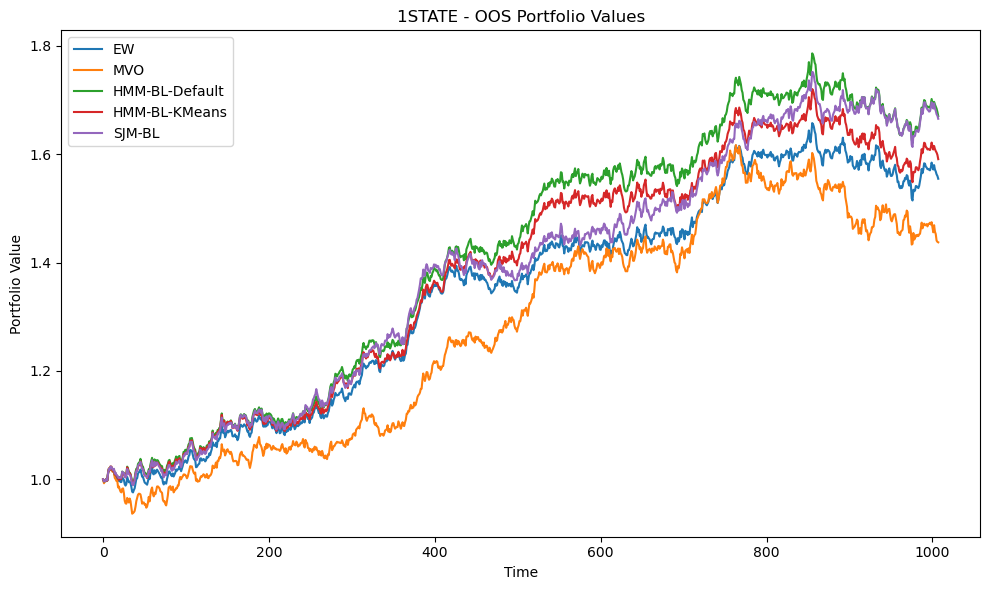

In [ ]:
    scenario_key = "1state"
    pvs_1 = results[scenario_key]["pvs"]
    plt.figure(figsize=(10, 6))
    for strat, vals in pvs_1.items():
        plt.plot(vals, label=strat)
    plt.title(f"{scenario_key.upper()} - OOS Portfolio Values")
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

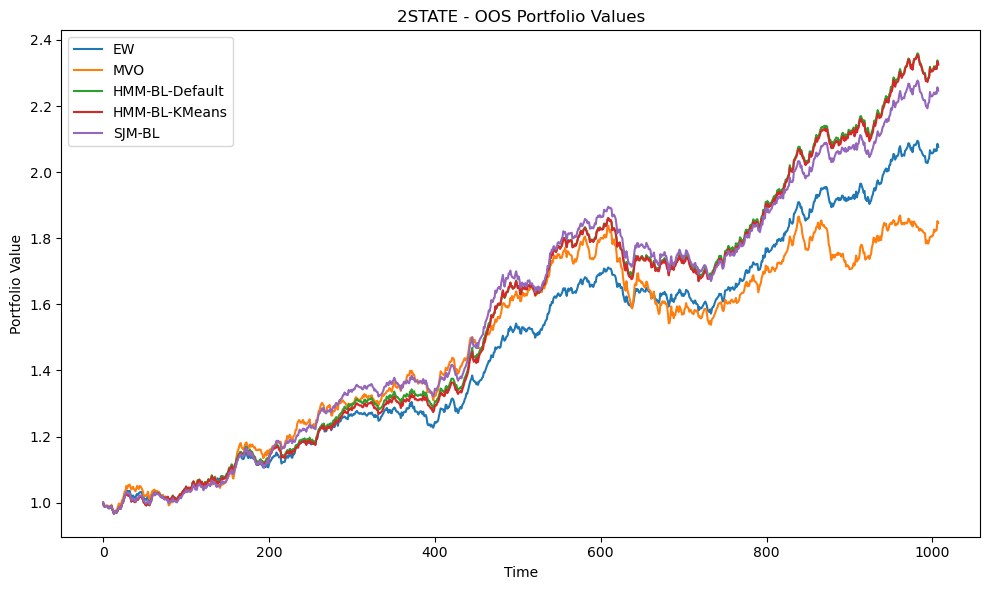

In [ ]:
    scenario_key = "2state"
    pvs_2 = results[scenario_key]["pvs"]
    plt.figure(figsize=(10, 6))
    for strat, vals in pvs_2.items():
        plt.plot(vals, label=strat)
    plt.title(f"{scenario_key.upper()} - OOS Portfolio Values")
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

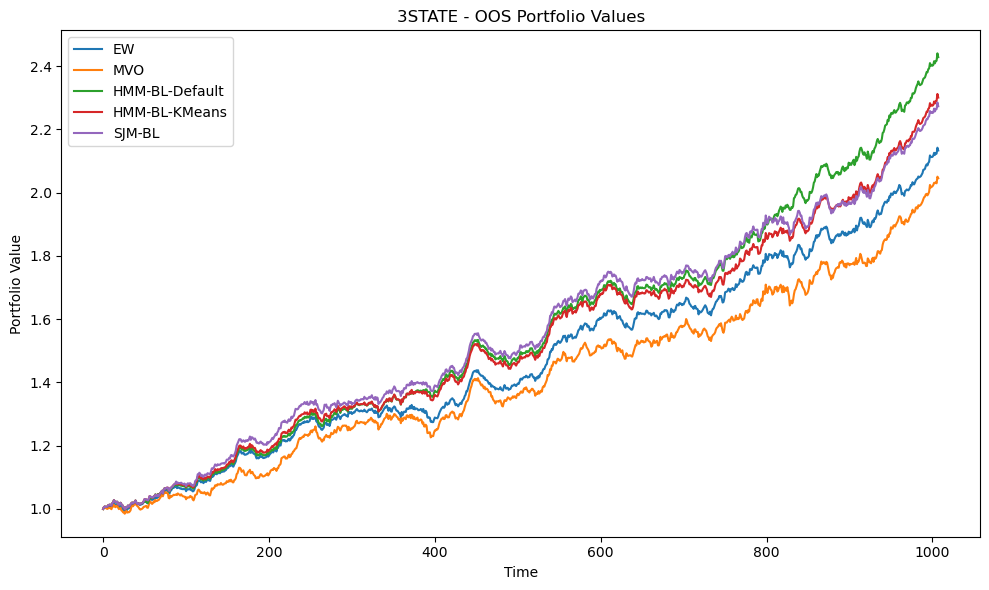

In [ ]:
    scenario_key = "3state"
    pvs_3 = results[scenario_key]["pvs"]
    plt.figure(figsize=(10, 6))
    for strat, vals in pvs_3.items():
        plt.plot(vals, label=strat)
    plt.title(f"{scenario_key.upper()} - OOS Portfolio Values")
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

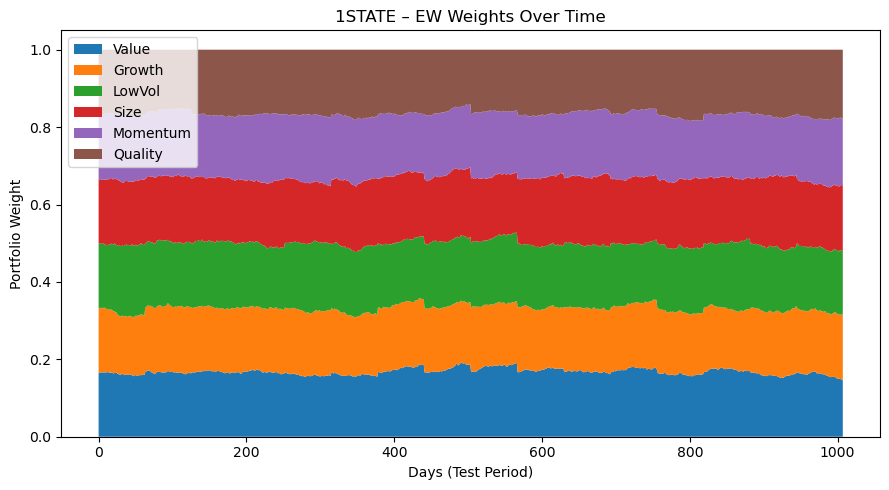

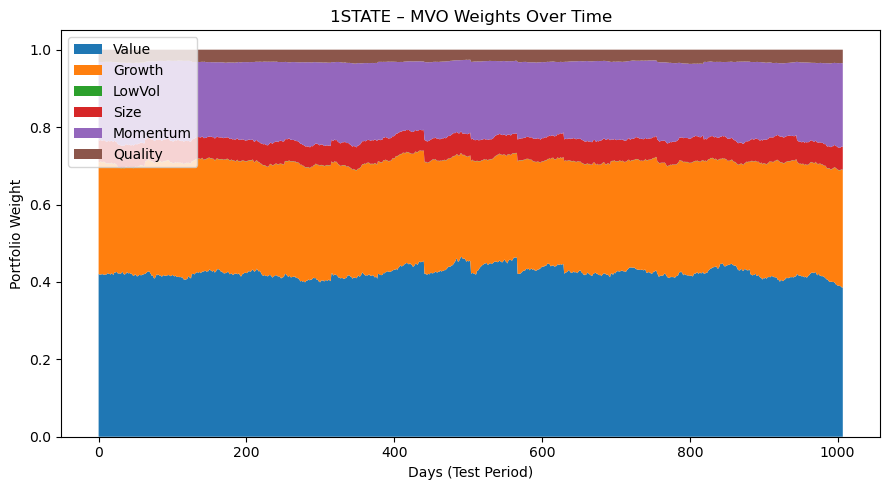

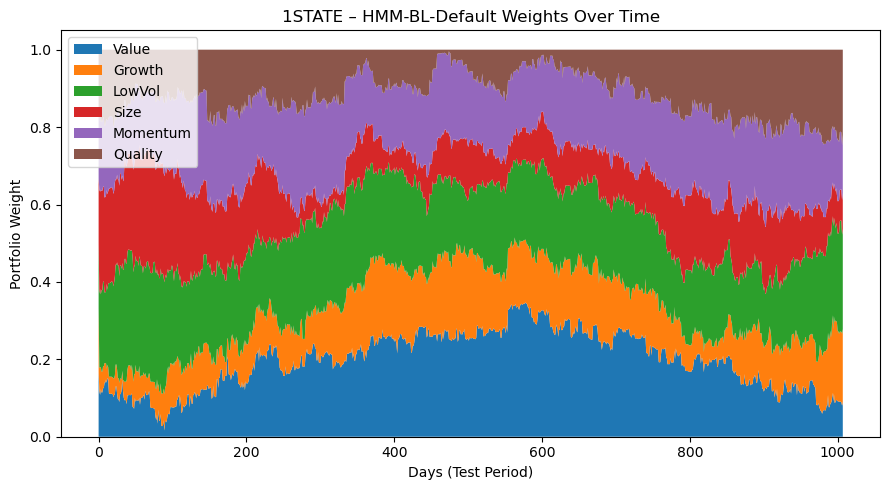

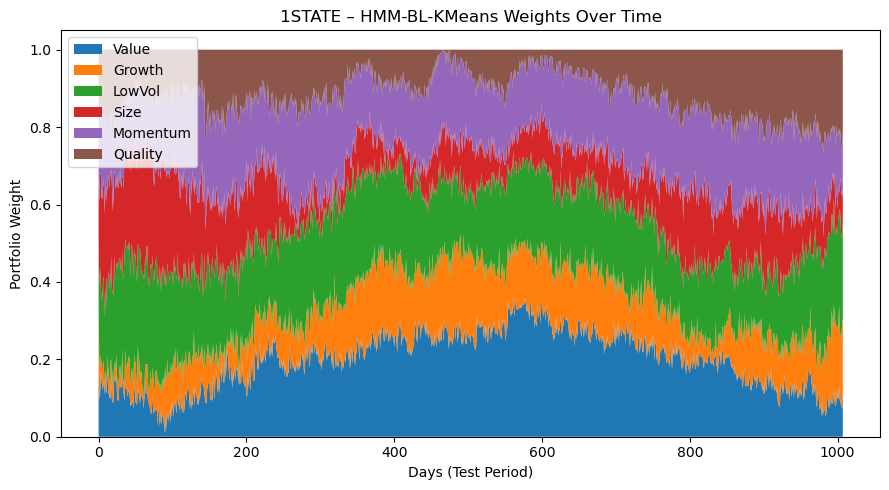

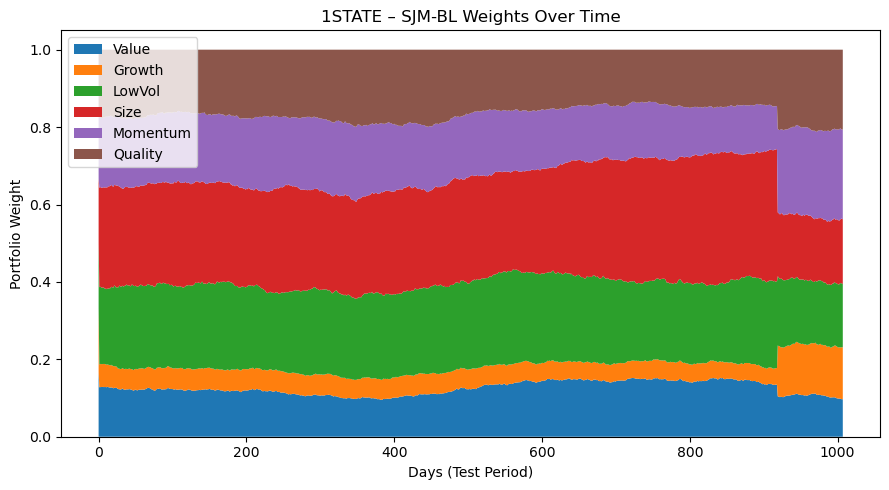

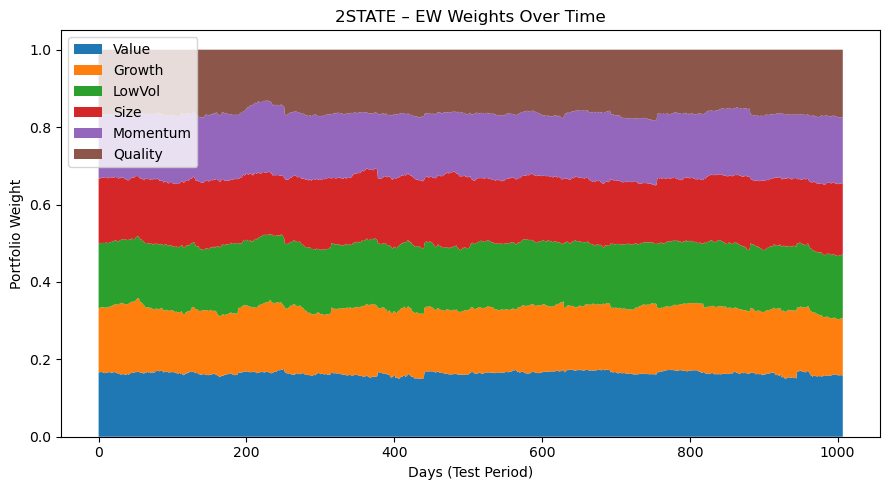

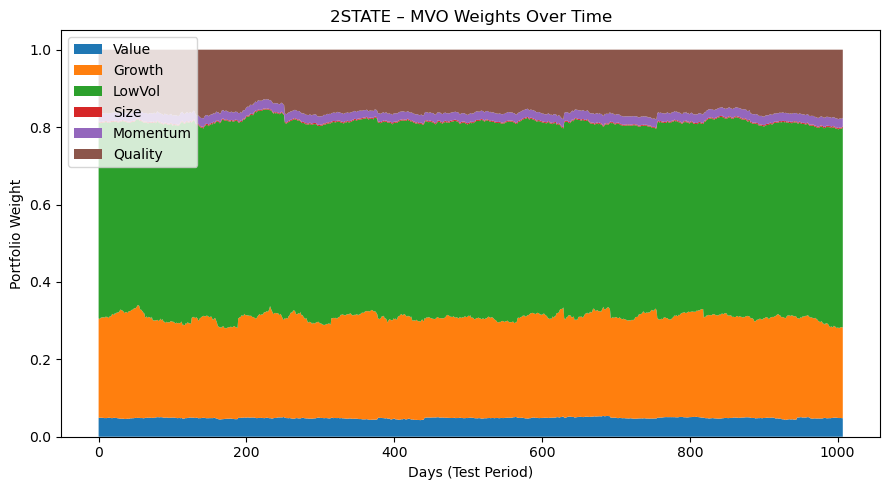

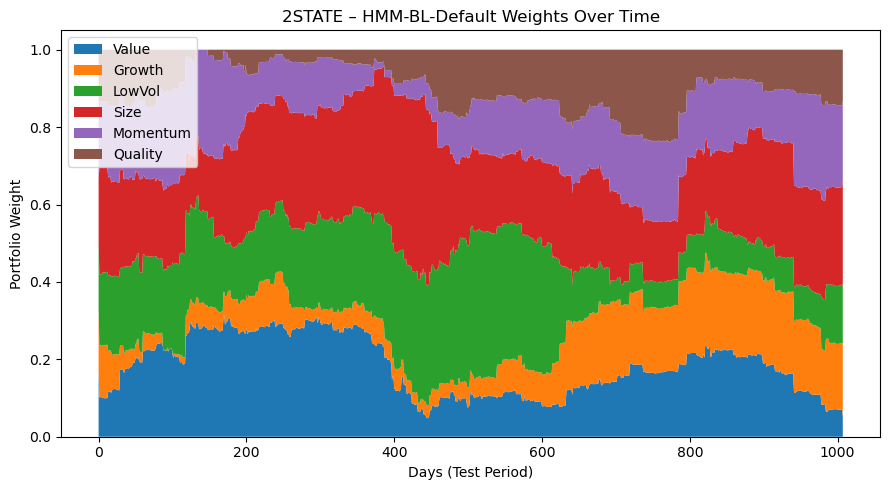

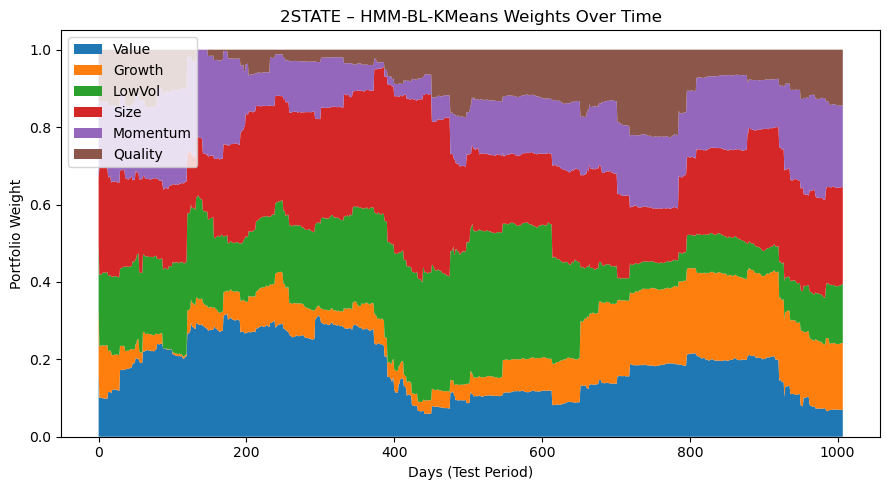

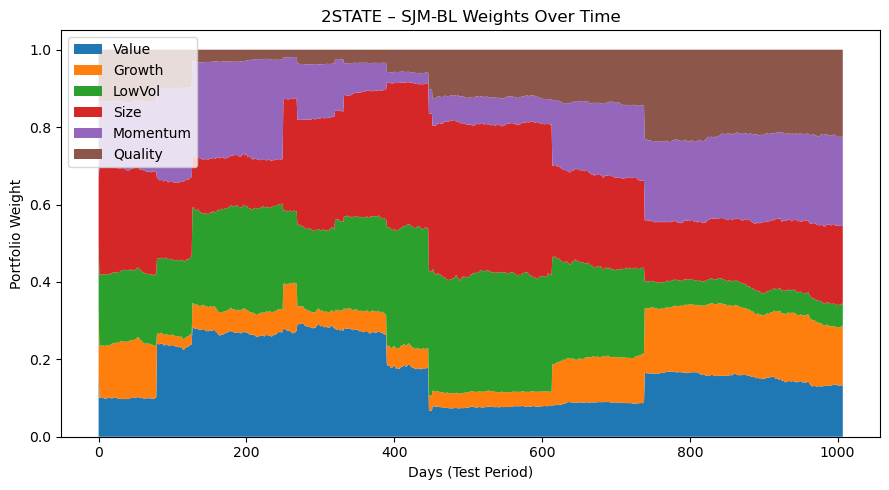

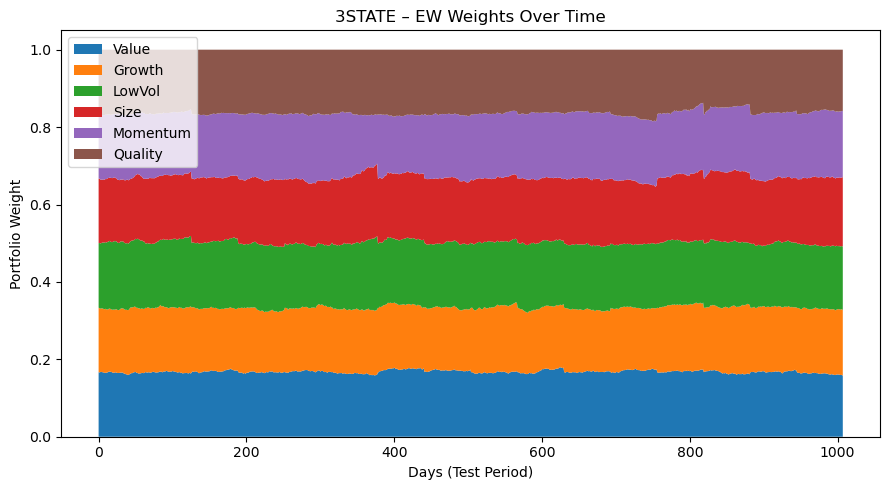

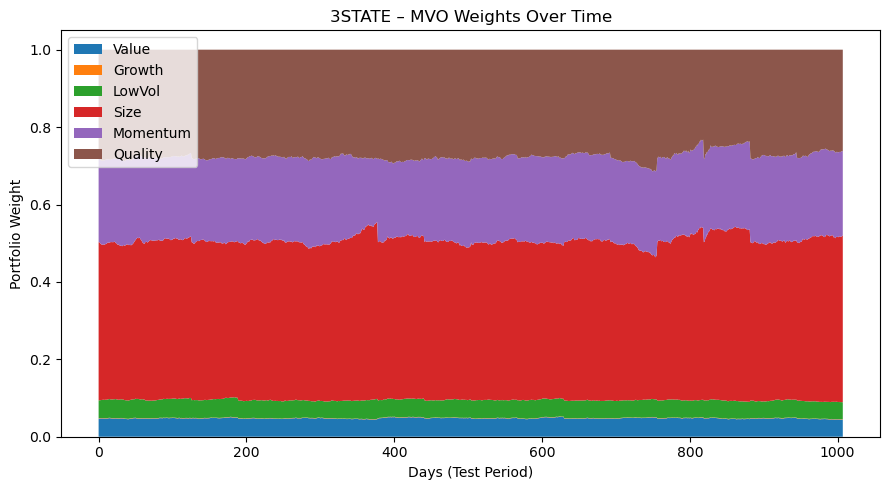

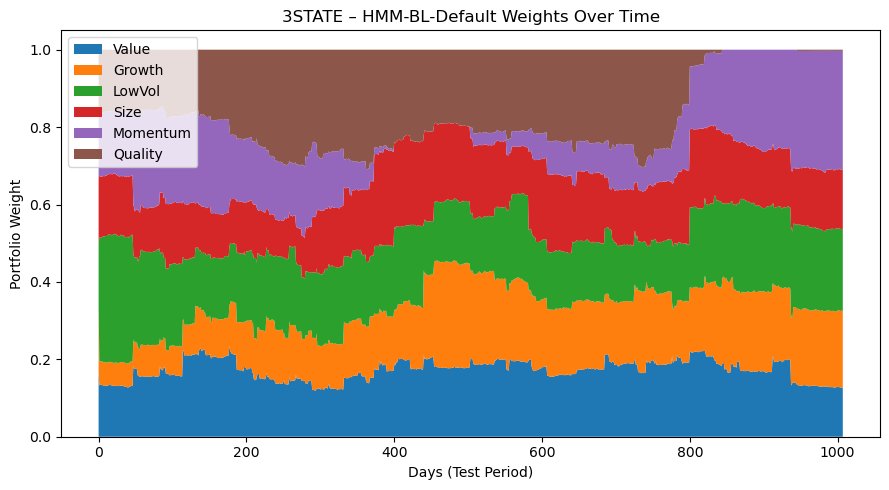

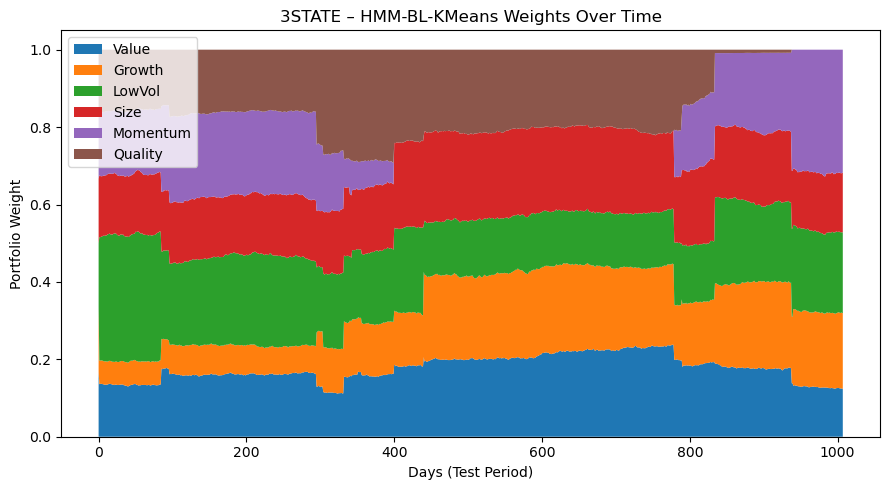

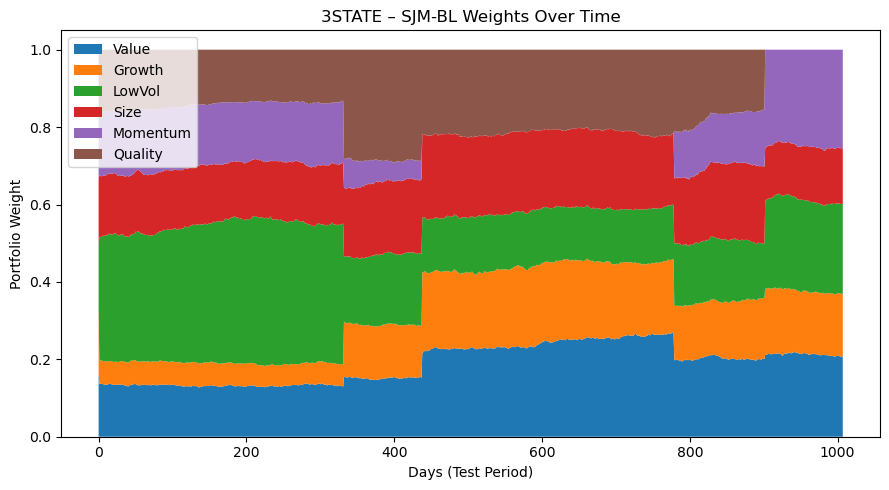

In [ ]:
scenarios = ["1state", "2state", "3state"]
for scenario in scenarios:
    W_dict = results[scenario]["weights"]          
    T_test = next(iter(W_dict.values())).shape[0]  

    for strategy, w_hist in W_dict.items():
        plt.figure(figsize=(9, 5))
        x_vals = np.arange(T_test)
        plt.stackplot(x_vals, *w_hist.T, labels=ASSETS)

        plt.title(f"{scenario.upper()} – {strategy} Weights Over Time")
        plt.xlabel("Days (Test Period)")
        plt.ylabel("Portfolio Weight")
        plt.legend(loc="upper left")
        plt.tight_layout()
        plt.show()

C:\Users\vri\AppData\Local\Temp\ipykernel_28224\1949573684.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


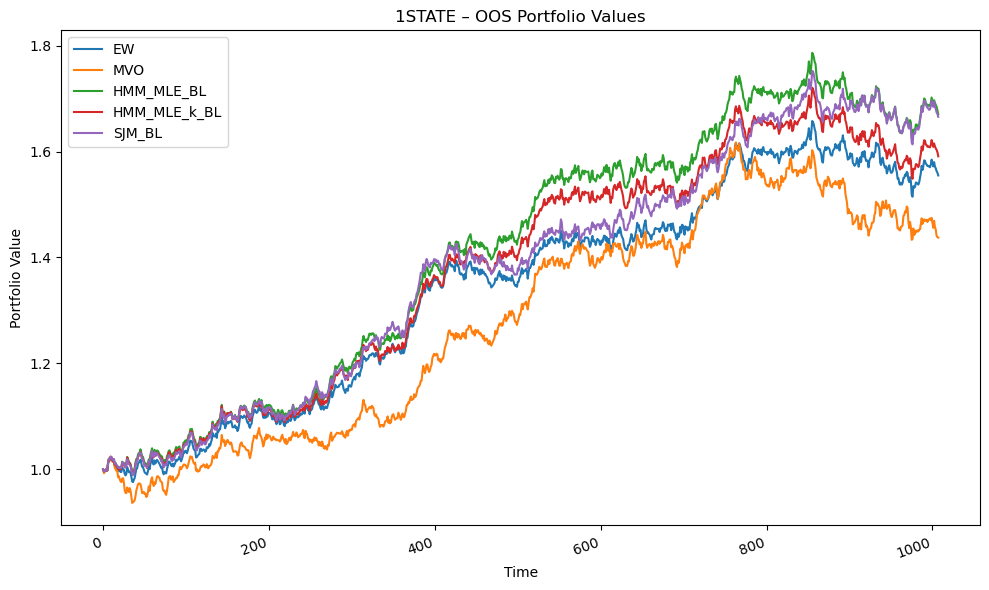

C:\Users\vri\AppData\Local\Temp\ipykernel_28224\1949573684.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


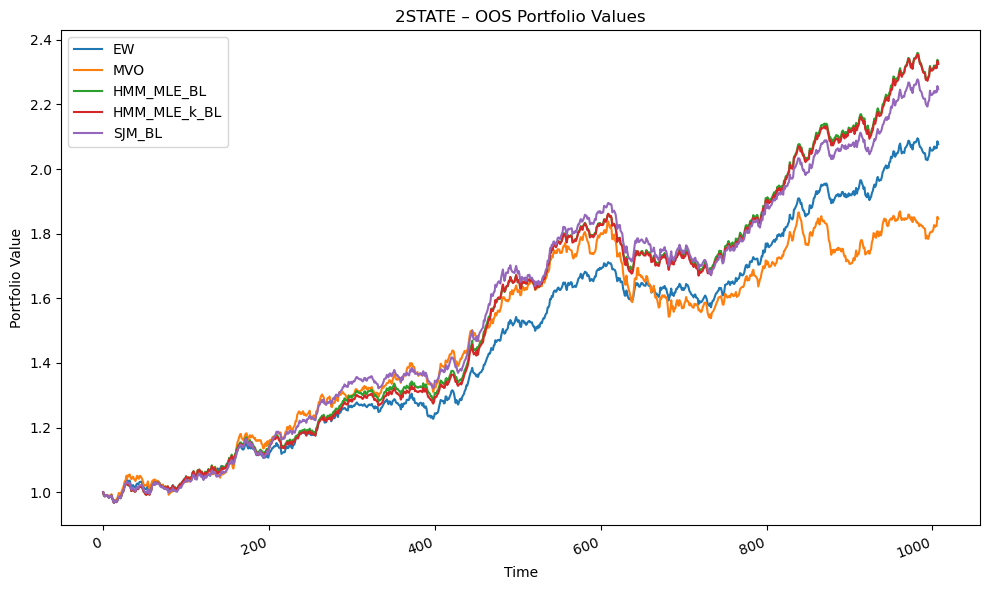

C:\Users\vri\AppData\Local\Temp\ipykernel_28224\1949573684.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


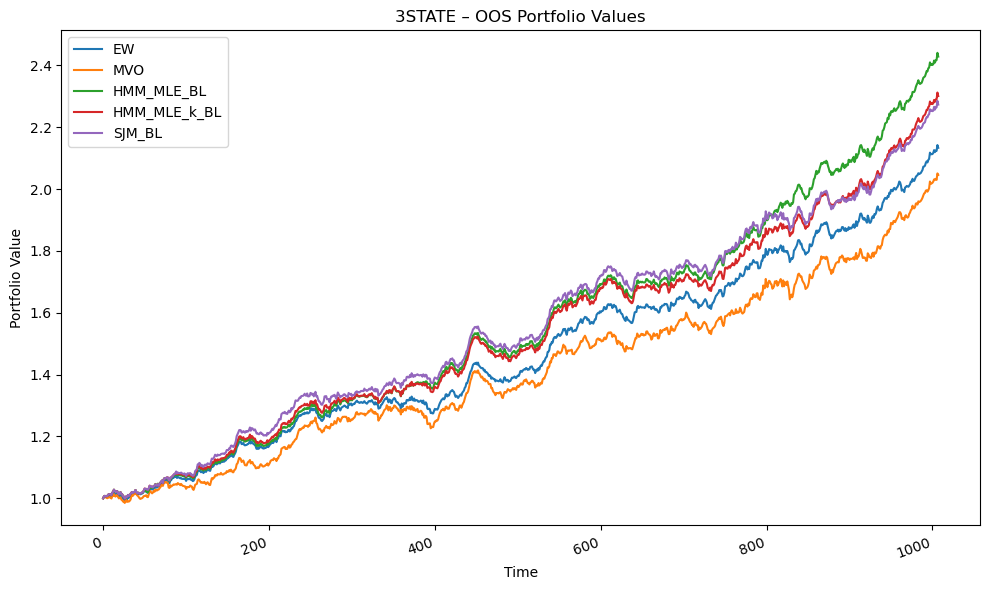

In [ ]:
scenarios = ["1state", "2state", "3state"]
pvs = {sc: results[sc]["pvs"] for sc in scenarios}

NAME_MAP = {
    "EW":               "EW",
    "MVO":              "MVO",
    "HMM-BL-Default":   "HMM_MLE_BL",
    "HMM-BL-KMeans":    "HMM_MLE_k_BL",
    "SJM-BL":           "SJM_BL",
}

def remap_axes(ax):
    handles, labels = ax.get_legend_handles_labels()
    if labels:
        new_labels = [NAME_MAP.get(l, l) for l in labels]
        ax.legend(handles, new_labels, loc="best")
    xt = ax.get_xticklabels()
    if xt:
        ax.set_xticklabels(
            [NAME_MAP.get(lbl.get_text(), lbl.get_text()) for lbl in xt],
            rotation=20, ha="right"
        )

for sc in scenarios:
    fig, ax = plt.subplots(figsize=(10, 6))
    for old in NAME_MAP:
        if old in pvs[sc]:
            ax.plot(pvs[sc][old], label=old)
    ax.set_title(f"{sc.upper()} – OOS Portfolio Values")
    ax.set_xlabel("Time")
    ax.set_ylabel("Portfolio Value")
    remap_axes(ax)
    plt.tight_layout()
    plt.show()

for fig_num in plt.get_fignums():
    fig = plt.figure(fig_num)
    for ax in fig.axes:
        remap_axes(ax)
    fig.canvas.draw()

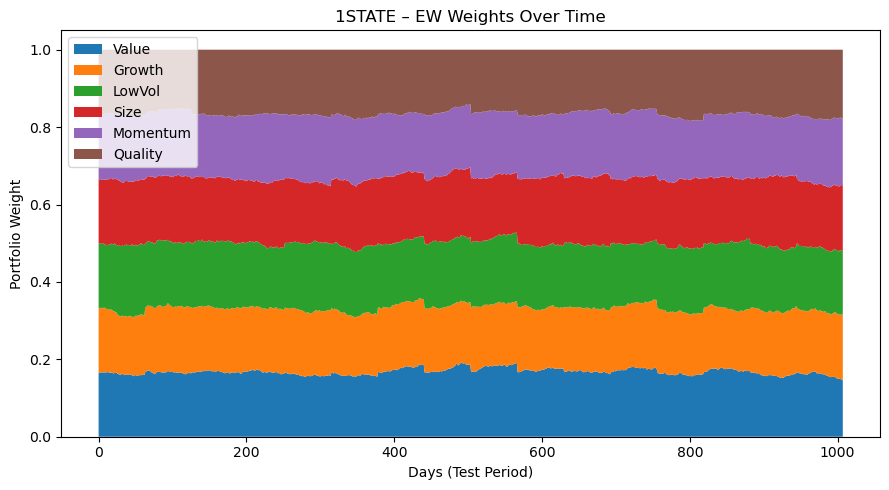

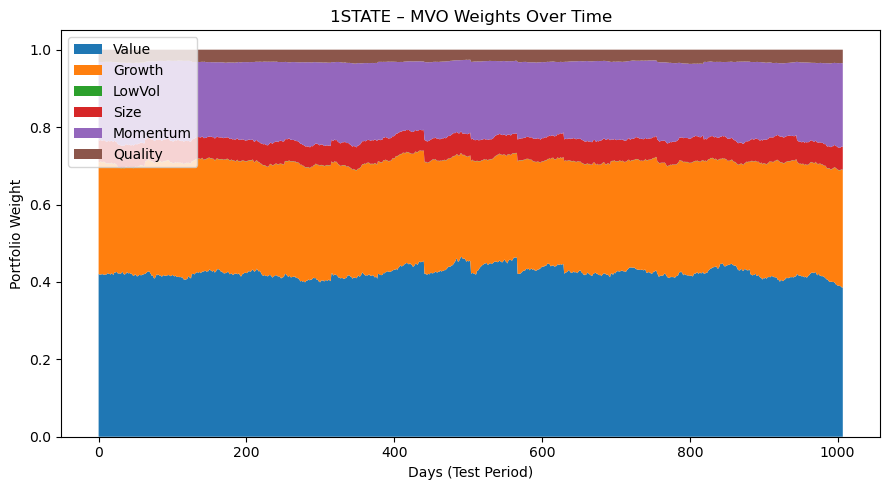

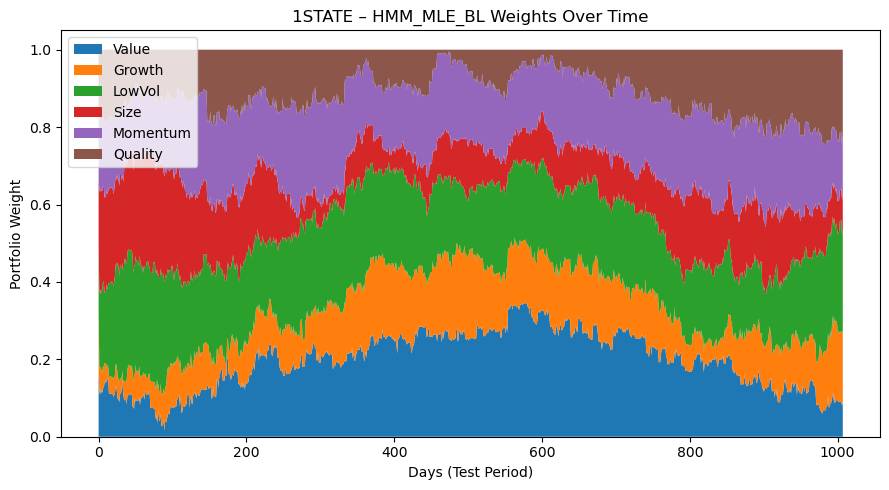

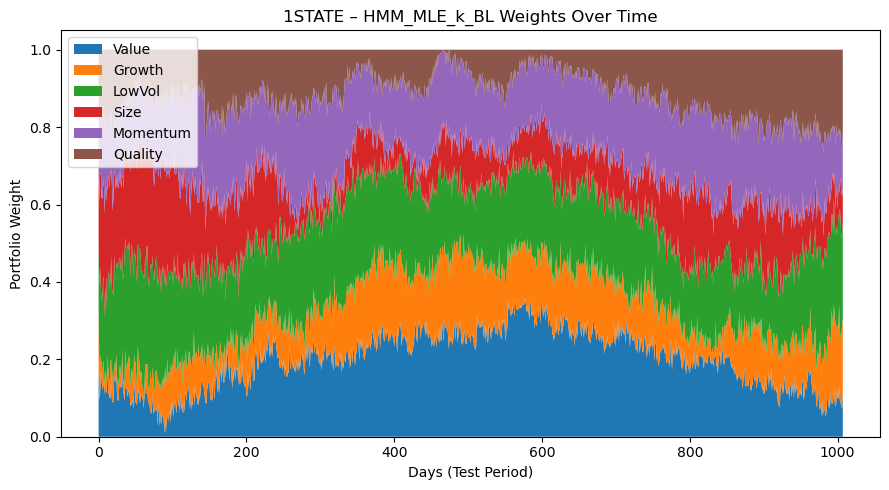

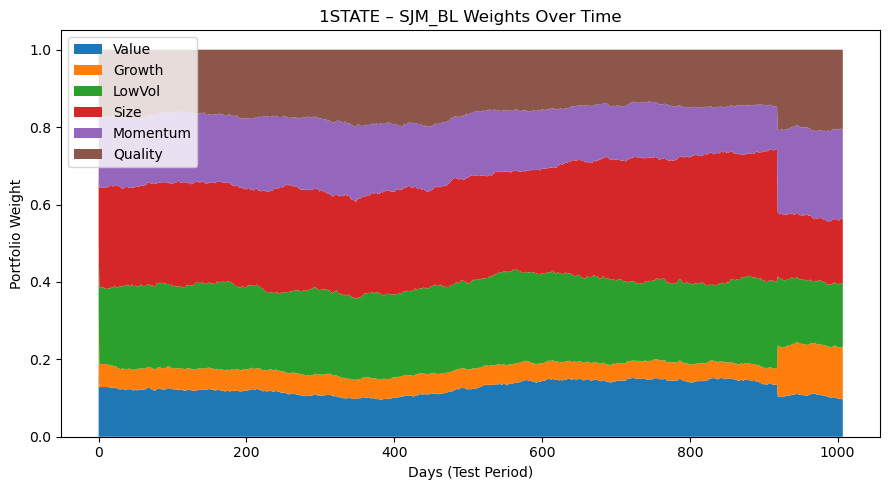

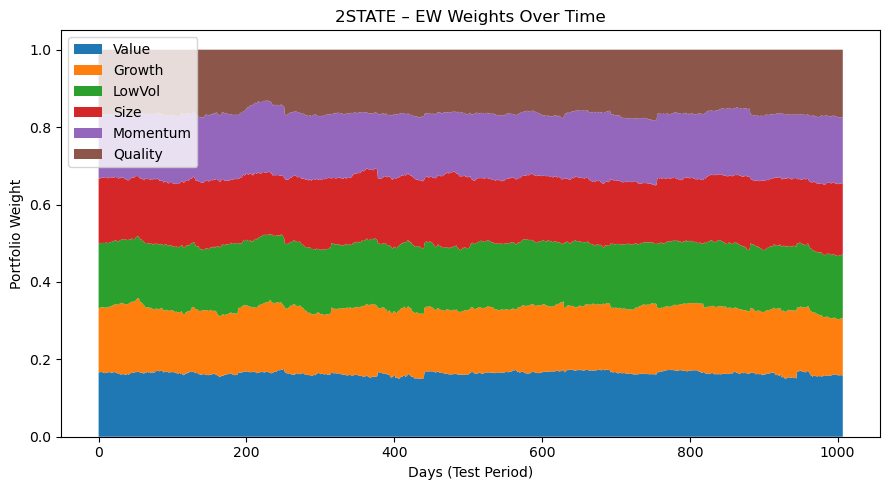

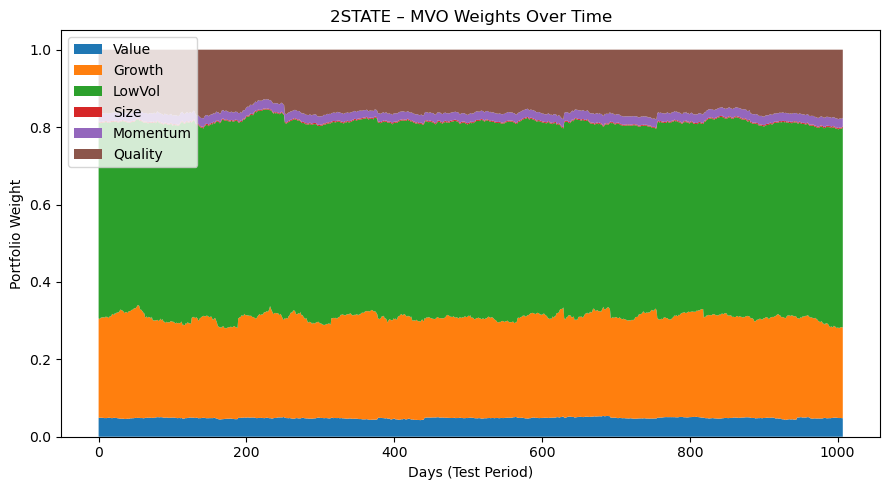

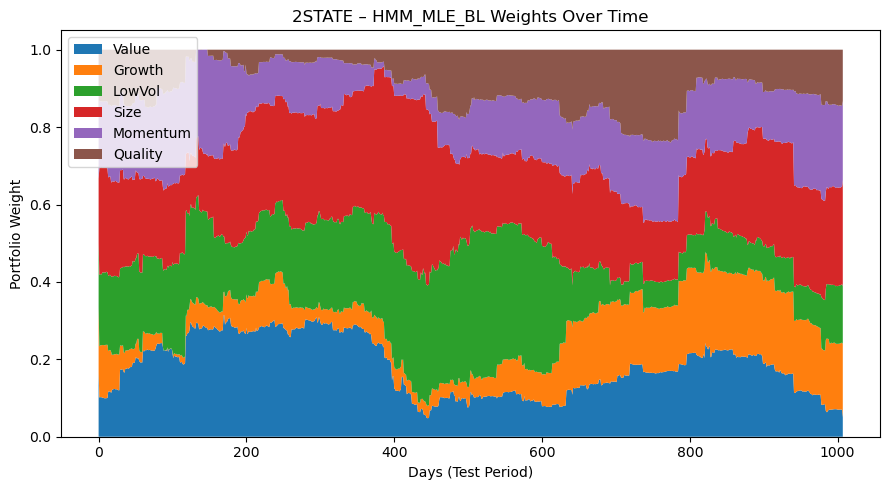

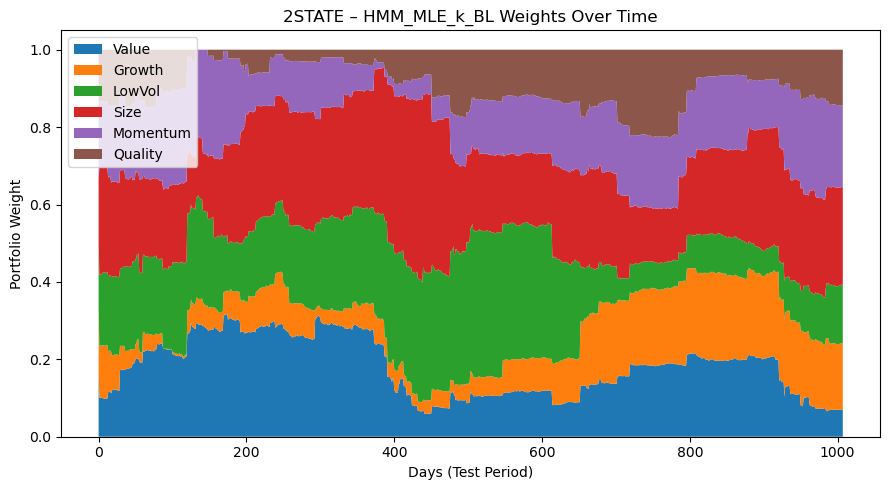

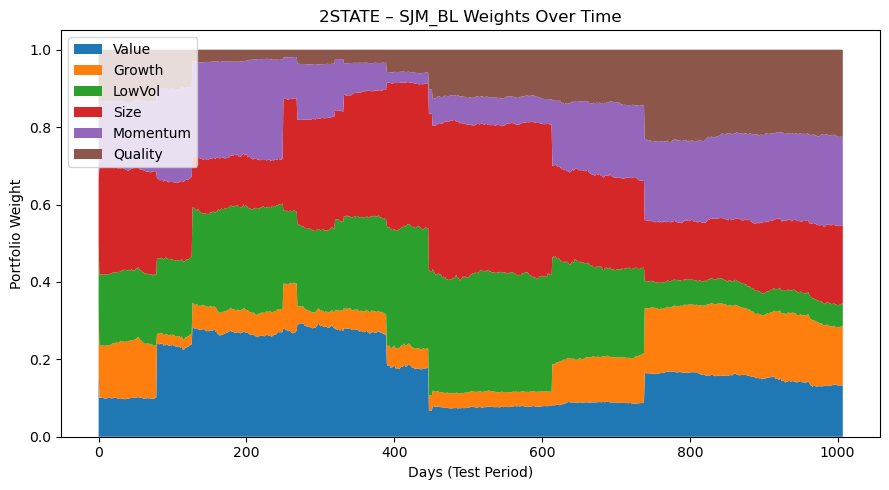

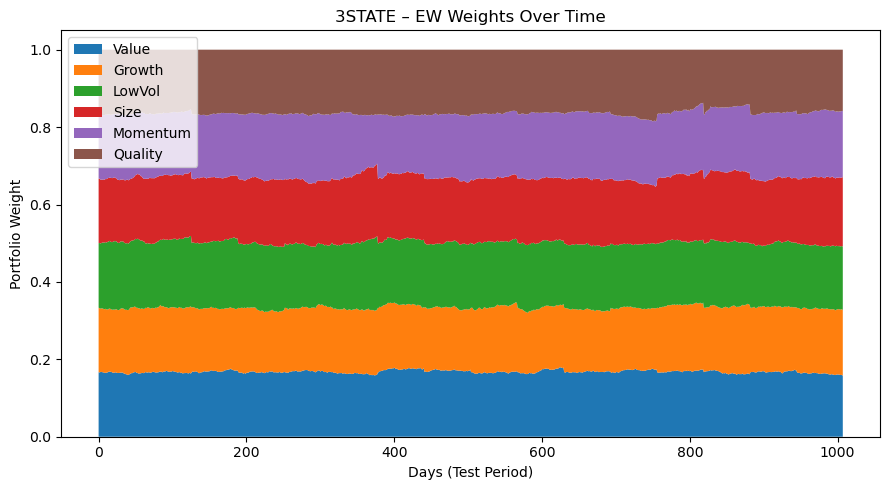

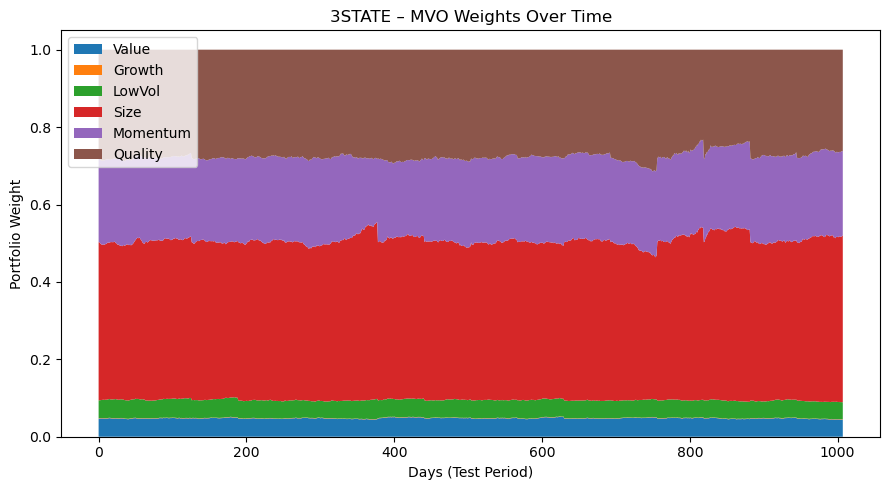

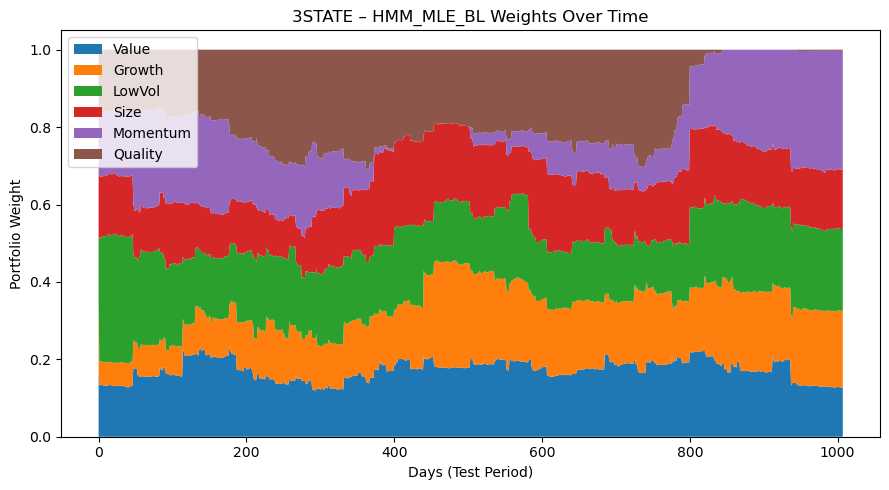

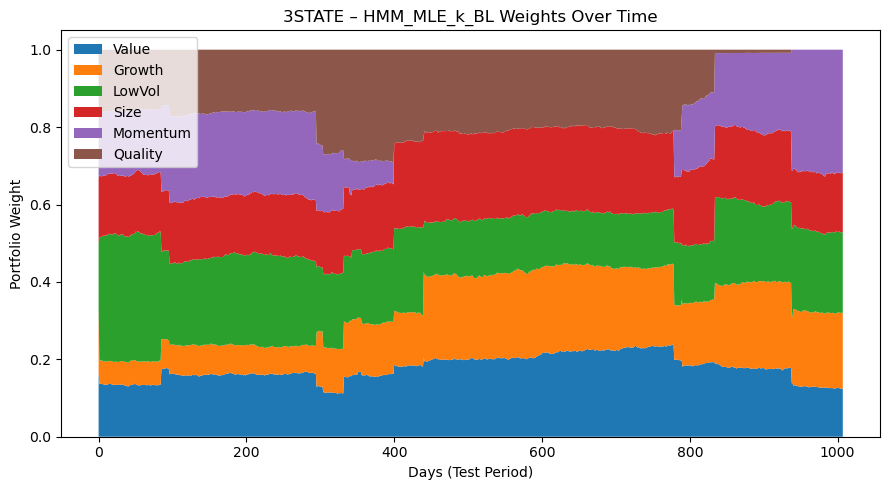

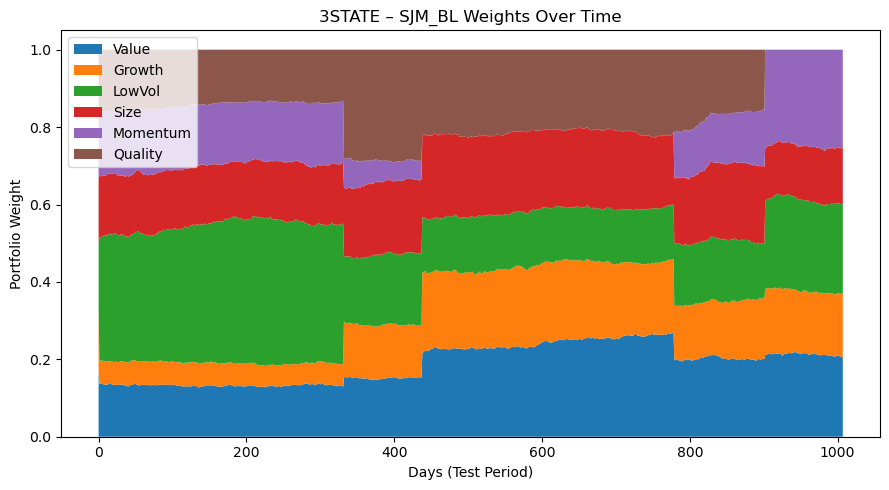

In [ ]:
NAME_MAP = {
    "EW":               "EW",
    "MVO":              "MVO",
    "HMM-BL-Default":   "HMM_MLE_BL",
    "HMM-BL-KMeans":    "HMM_MLE_k_BL",
    "SJM-BL":           "SJM_BL",
}

import numpy as np
import matplotlib.pyplot as plt

scenarios = ["1state", "2state", "3state"]
for sc in scenarios:
    W_dict = results[sc]["weights"]
    T_test = next(iter(W_dict.values())).shape[0]

    for strat_old, w_hist in W_dict.items():
        strat_new = NAME_MAP.get(strat_old, strat_old)
        plt.figure(figsize=(9,5))
        x = np.arange(T_test)
        plt.stackplot(x, *w_hist.T, labels=ASSETS)
        plt.title(f"{sc.upper()} – {strat_new} Weights Over Time")
        plt.xlabel("Days (Test Period)")
        plt.ylabel("Portfolio Weight")
        plt.legend(loc="upper left")
        plt.tight_layout()
        plt.show()